## Import

In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from tqdm import tqdm
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import json
from imblearn.over_sampling import SMOTE

tqdm.pandas()

## Data Load

In [2]:
BASE_DIR = "./data"

train_meta = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
train_A = pd.read_csv(os.path.join(BASE_DIR, "train", "A.csv"))
train_B = pd.read_csv(os.path.join(BASE_DIR, "train", "B.csv"))

print("train_meta:", train_meta.shape)
print("train_A:", train_A.shape)
print("train_B:", train_B.shape)

train_meta: (944767, 3)
train_A: (647241, 37)
train_B: (297526, 31)


## Data Pre-processing

In [3]:
def convert_age(val):
    if pd.isna(val): return np.nan
    try:
        base = int(str(val)[:-1])
        return base if str(val)[-1] == "a" else base + 5
    except:
        return np.nan

def split_testdate(val):
    try:
        v = int(val)
        return v // 100, v % 100
    except:
        return np.nan, np.nan

def seq_mean(series):
    return series.fillna("").progress_apply(
        lambda x: np.fromstring(x, sep=",").mean() if x else np.nan
    )

def seq_std(series):
    return series.fillna("").progress_apply(
        lambda x: np.fromstring(x, sep=",").std() if x else np.nan
    )

def seq_rate(series, target="1"):
    return series.fillna("").progress_apply(
        lambda x: str(x).split(",").count(target) / len(x.split(",")) if x else np.nan
    )

def masked_mean_from_csv_series(cond_series, val_series, mask_val):
    cond_df = cond_series.fillna("").str.split(",", expand=True).replace("", np.nan)
    val_df  = val_series.fillna("").str.split(",", expand=True).replace("", np.nan)

    cond_arr = cond_df.to_numpy(dtype=float)
    val_arr  = val_df.to_numpy(dtype=float)

    mask = (cond_arr == mask_val)
    with np.errstate(invalid="ignore"):
        sums = np.nansum(np.where(mask, val_arr, np.nan), axis=1)
        counts = np.sum(mask, axis=1)
        out = sums / np.where(counts==0, np.nan, counts)
    return pd.Series(out, index=cond_series.index)

def masked_mean_in_set_series(cond_series, val_series, mask_set):
    cond_df = cond_series.fillna("").str.split(",", expand=True).replace("", np.nan)
    val_df  = val_series.fillna("").str.split(",", expand=True).replace("", np.nan)

    cond_arr = cond_df.to_numpy(dtype=float)
    val_arr  = val_df.to_numpy(dtype=float)

    mask = np.isin(cond_arr, list(mask_set))
    with np.errstate(invalid="ignore"):
        sums = np.nansum(np.where(mask, val_arr, np.nan), axis=1)
        counts = np.sum(mask, axis=1)
        out = sums / np.where(counts == 0, np.nan, counts)
    return pd.Series(out, index=cond_series.index)

## 1차 Feature Engineering

In [4]:
def preprocess_A(train_A):
    df = train_A.copy()
    
    # ---- Age, TestDate 파생 ----
    print("Step 1: Age, TestDate 파생...")
    df["Age_num"] = df["Age"].map(convert_age)
    ym = df["TestDate"].map(split_testdate)
    df["Year"] = [y for y, m in ym]
    df["Month"] = [m for y, m in ym]

    feats = pd.DataFrame(index=df.index)

    # ---- A1 ----
    print("Step 2: A1 feature 생성...")
    feats["A1_resp_rate"] = seq_rate(df["A1-3"], "1")
    feats["A1_rt_mean"]   = seq_mean(df["A1-4"])
    feats["A1_rt_std"]    = seq_std(df["A1-4"])
    feats["A1_rt_left"]   = masked_mean_from_csv_series(df["A1-1"], df["A1-4"], 1)
    feats["A1_rt_right"]  = masked_mean_from_csv_series(df["A1-1"], df["A1-4"], 2)
    feats["A1_rt_side_diff"] = feats["A1_rt_left"] - feats["A1_rt_right"]
    feats["A1_rt_slow"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 1)
    feats["A1_rt_fast"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 3)
    feats["A1_rt_speed_diff"] = feats["A1_rt_slow"] - feats["A1_rt_fast"]

    # ---- A2 ----
    print("Step 3: A2 feature 생성...")
    feats["A2_resp_rate"] = seq_rate(df["A2-3"], "1")
    feats["A2_rt_mean"]   = seq_mean(df["A2-4"])
    feats["A2_rt_std"]    = seq_std(df["A2-4"])
    feats["A2_rt_cond1_diff"] = masked_mean_from_csv_series(df["A2-1"], df["A2-4"], 1) - \
                                masked_mean_from_csv_series(df["A2-1"], df["A2-4"], 3)
    feats["A2_rt_cond2_diff"] = masked_mean_from_csv_series(df["A2-2"], df["A2-4"], 1) - \
                                masked_mean_from_csv_series(df["A2-2"], df["A2-4"], 3)

    # ---- A3 ----
    print("Step 4: A3 feature 생성...")
    s = df["A3-5"].fillna("")
    total   = s.apply(lambda x: len(x.split(",")) if x else 0)
    valid   = s.apply(lambda x: sum(v in {"1","2"} for v in x.split(",")) if x else 0)
    invalid = s.apply(lambda x: sum(v in {"3","4"} for v in x.split(",")) if x else 0)
    correct = s.apply(lambda x: sum(v in {"1","3"} for v in x.split(",")) if x else 0)
    feats["A3_valid_ratio"]   = (valid / total).replace([np.inf,-np.inf], np.nan)
    feats["A3_invalid_ratio"] = (invalid / total).replace([np.inf,-np.inf], np.nan)
    feats["A3_correct_ratio"] = (correct / total).replace([np.inf,-np.inf], np.nan)

    feats["A3_resp2_rate"] = seq_rate(df["A3-6"], "1")
    feats["A3_rt_mean"]    = seq_mean(df["A3-7"])
    feats["A3_rt_std"]     = seq_std(df["A3-7"])
    feats["A3_rt_size_diff"] = masked_mean_from_csv_series(df["A3-1"], df["A3-7"], 1) - \
                               masked_mean_from_csv_series(df["A3-1"], df["A3-7"], 2)
    feats["A3_rt_side_diff"] = masked_mean_from_csv_series(df["A3-3"], df["A3-7"], 1) - \
                               masked_mean_from_csv_series(df["A3-3"], df["A3-7"], 2)

    # ---- A4 ----
    print("Step 5: A4 feature 생성...")
    feats["A4_acc_rate"]   = seq_rate(df["A4-3"], "1")
    feats["A4_resp2_rate"] = seq_rate(df["A4-4"], "1")
    feats["A4_rt_mean"]    = seq_mean(df["A4-5"])
    feats["A4_rt_std"]     = seq_std(df["A4-5"])
    feats["A4_stroop_diff"] = masked_mean_from_csv_series(df["A4-1"], df["A4-5"], 2) - \
                              masked_mean_from_csv_series(df["A4-1"], df["A4-5"], 1)
    feats["A4_rt_color_diff"] = masked_mean_from_csv_series(df["A4-2"], df["A4-5"], 1) - \
                                masked_mean_from_csv_series(df["A4-2"], df["A4-5"], 2)

    # ---- A5 ----
    print("Step 6: A5 feature 생성...")
    feats["A5_acc_rate"]   = seq_rate(df["A5-2"], "1")
    feats["A5_resp2_rate"] = seq_rate(df["A5-3"], "1")
    feats["A5_acc_nonchange"] = masked_mean_from_csv_series(df["A5-1"], df["A5-2"], 1)
    feats["A5_acc_change"]    = masked_mean_in_set_series(df["A5-1"], df["A5-2"], {2,3,4})

    # ---- Drop ----
    print("Step 7: 시퀀스 컬럼 drop & concat...")
    seq_cols = [
        "A1-1","A1-2","A1-3","A1-4",
        "A2-1","A2-2","A2-3","A2-4",
        "A3-1","A3-2","A3-3","A3-4","A3-5","A3-6","A3-7",
        "A4-1","A4-2","A4-3","A4-4","A4-5",
        "A5-1","A5-2","A5-3"
    ]
    print("A 검사 데이터 전처리 완료")
    return pd.concat([df.drop(columns=seq_cols, errors="ignore"), feats], axis=1)

In [5]:
def preprocess_B(train_B):
    df = train_B.copy()

    # ---- Age, TestDate ----
    print("Step 1: Age, TestDate 파생...")
    df["Age_num"] = df["Age"].map(convert_age)
    ym = df["TestDate"].map(split_testdate)
    df["Year"] = [y for y, m in ym]
    df["Month"] = [m for y, m in ym]

    feats = pd.DataFrame(index=df.index)

    # ---- B1 ----
    print("Step 2: B1 feature 생성...")
    feats["B1_acc_task1"] = seq_rate(df["B1-1"], "1")
    feats["B1_rt_mean"]   = seq_mean(df["B1-2"])
    feats["B1_rt_std"]    = seq_std(df["B1-2"])
    feats["B1_acc_task2"] = seq_rate(df["B1-3"], "1")

    # ---- B2 ----
    print("Step 3: B2 feature 생성...")
    feats["B2_acc_task1"] = seq_rate(df["B2-1"], "1")
    feats["B2_rt_mean"]   = seq_mean(df["B2-2"])
    feats["B2_rt_std"]    = seq_std(df["B2-2"])
    feats["B2_acc_task2"] = seq_rate(df["B2-3"], "1")

    # ---- B3 ----
    print("Step 4: B3 feature 생성...")
    feats["B3_acc_rate"] = seq_rate(df["B3-1"], "1")
    feats["B3_rt_mean"]  = seq_mean(df["B3-2"])
    feats["B3_rt_std"]   = seq_std(df["B3-2"])

    # ---- B4 ----
    print("Step 5: B4 feature 생성...")
    feats["B4_acc_rate"] = seq_rate(df["B4-1"], "1")
    feats["B4_rt_mean"]  = seq_mean(df["B4-2"])
    feats["B4_rt_std"]   = seq_std(df["B4-2"])

    # ---- B5 ----
    print("Step 6: B5 feature 생성...")
    feats["B5_acc_rate"] = seq_rate(df["B5-1"], "1")
    feats["B5_rt_mean"]  = seq_mean(df["B5-2"])
    feats["B5_rt_std"]   = seq_std(df["B5-2"])

    # ---- B6~B8 ----
    print("Step 7: B6~B8 feature 생성...")
    feats["B6_acc_rate"] = seq_rate(df["B6"], "1")
    feats["B7_acc_rate"] = seq_rate(df["B7"], "1")
    feats["B8_acc_rate"] = seq_rate(df["B8"], "1")

    # ---- Drop ----
    print("Step 8: 시퀀스 컬럼 drop & concat...")
    seq_cols = [
        "B1-1","B1-2","B1-3",
        "B2-1","B2-2","B2-3",
        "B3-1","B3-2",
        "B4-1","B4-2",
        "B5-1","B5-2",
        "B6","B7","B8"
    ]

    print("B 검사 데이터 전처리 완료")
    return pd.concat([df.drop(columns=seq_cols, errors="ignore"), feats], axis=1)

In [6]:
train_A_features = preprocess_A(train_A)
train_B_features = preprocess_B(train_B)

print("A:", train_A_features.shape, "B:", train_B_features.shape)

Step 1: Age, TestDate 파생...
Step 2: A1 feature 생성...


100%|██████████| 647241/647241 [00:07<00:00, 87019.08it/s]


Step 3: A2 feature 생성...


100%|██████████| 647241/647241 [00:07<00:00, 87152.33it/s]


Step 4: A3 feature 생성...


100%|██████████| 647241/647241 [00:08<00:00, 76105.44it/s]


Step 5: A4 feature 생성...


100%|██████████| 647241/647241 [00:11<00:00, 54552.60it/s]


Step 6: A5 feature 생성...


100%|██████████| 647241/647241 [00:01<00:00, 563417.91it/s]


Step 7: 시퀀스 컬럼 drop & concat...
A 검사 데이터 전처리 완료
Step 1: Age, TestDate 파생...
Step 2: B1 feature 생성...


100%|██████████| 297526/297526 [00:00<00:00, 806461.50it/s]


Step 3: B2 feature 생성...


100%|██████████| 297526/297526 [00:00<00:00, 779859.31it/s]


Step 4: B3 feature 생성...


100%|██████████| 297526/297526 [00:03<00:00, 86973.90it/s]


Step 5: B4 feature 생성...


100%|██████████| 297526/297526 [00:04<00:00, 61439.04it/s]


Step 6: B5 feature 생성...


100%|██████████| 297526/297526 [00:03<00:00, 84535.84it/s]


Step 7: B6~B8 feature 생성...


100%|██████████| 297526/297526 [00:00<00:00, 1032554.58it/s]

Step 8: 시퀀스 컬럼 drop & concat...
B 검사 데이터 전처리 완료
A: (647241, 49) B: (297526, 39)


## 2차 Feature Engineering

In [7]:
# -------- 공통 유틸 --------
def _has(df, cols):  # 필요한 컬럼이 모두 있는지
    return all(c in df.columns for c in cols)

def _safe_div(a, b, eps=1e-6):
    return a / (b + eps)

# -------- A 파생 --------
def add_features_A(df: pd.DataFrame) -> pd.DataFrame:
    feats = df.copy()
    eps = 1e-6

    # 0) Year-Month 단일축
    if _has(feats, ["Year","Month"]):
        feats["YearMonthIndex"] = feats["Year"] * 12 + feats["Month"]

    # 1) 속도-정확도 트레이드오프
    if _has(feats, ["A1_rt_mean","A1_resp_rate"]):
        feats["A1_speed_acc_tradeoff"] = _safe_div(feats["A1_rt_mean"], feats["A1_resp_rate"], eps)
    if _has(feats, ["A2_rt_mean","A2_resp_rate"]):
        feats["A2_speed_acc_tradeoff"] = _safe_div(feats["A2_rt_mean"], feats["A2_resp_rate"], eps)
    if _has(feats, ["A4_rt_mean","A4_acc_rate"]):
        feats["A4_speed_acc_tradeoff"] = _safe_div(feats["A4_rt_mean"], feats["A4_acc_rate"], eps)

    # 2) RT 변동계수(CV)
    for k in ["A1","A2","A3","A4"]:
        m, s = f"{k}_rt_mean", f"{k}_rt_std"
        if _has(feats, [m, s]):
            feats[f"{k}_rt_cv"] = _safe_div(feats[s], feats[m], eps)

    # 3) 조건 차이 절댓값(편향 크기)
    for name, base in [
        ("A1_rt_side_gap_abs",  "A1_rt_side_diff"),
        ("A1_rt_speed_gap_abs", "A1_rt_speed_diff"),
        ("A2_rt_cond1_gap_abs", "A2_rt_cond1_diff"),
        ("A2_rt_cond2_gap_abs", "A2_rt_cond2_diff"),
        ("A4_stroop_gap_abs",   "A4_stroop_diff"),
        ("A4_color_gap_abs",    "A4_rt_color_diff"),
    ]:
        if base in feats.columns:
            feats[name] = feats[base].abs()

    # 4) 정확도 패턴 심화
    if _has(feats, ["A3_valid_ratio","A3_invalid_ratio"]):
        feats["A3_valid_invalid_gap"] = feats["A3_valid_ratio"] - feats["A3_invalid_ratio"]
    if _has(feats, ["A3_correct_ratio","A3_invalid_ratio"]):
        feats["A3_correct_invalid_gap"] = feats["A3_correct_ratio"] - feats["A3_invalid_ratio"]
    if _has(feats, ["A5_acc_change","A5_acc_nonchange"]):
        feats["A5_change_nonchange_gap"] = feats["A5_acc_change"] - feats["A5_acc_nonchange"]

    # 5) 간단 메타 리스크 스코어(휴리스틱)
    parts = []
    if "A4_stroop_gap_abs" in feats: parts.append(0.30 * feats["A4_stroop_gap_abs"].fillna(0))
    if "A4_acc_rate" in feats:       parts.append(0.20 * (1 - feats["A4_acc_rate"].fillna(0)))
    if "A3_valid_invalid_gap" in feats:
        parts.append(0.20 * feats["A3_valid_invalid_gap"].fillna(0).abs())
    if "A1_rt_cv" in feats: parts.append(0.20 * feats["A1_rt_cv"].fillna(0))
    if "A2_rt_cv" in feats: parts.append(0.10 * feats["A2_rt_cv"].fillna(0))
    if parts:
        feats["RiskScore"] = sum(parts)

    # NaN/inf 정리
    feats.replace([np.inf, -np.inf], np.nan, inplace=True)
    return feats

# -------- B 파생 --------
def add_features_B(df: pd.DataFrame) -> pd.DataFrame:
    feats = df.copy()
    eps = 1e-6

    # 0) Year-Month 단일축
    if _has(feats, ["Year","Month"]):
        feats["YearMonthIndex"] = feats["Year"] * 12 + feats["Month"]

    # 1) 속도-정확도 트레이드오프 (B1~B5)
    for k, acc_col, rt_col in [
        ("B1", "B1_acc_task1", "B1_rt_mean"),
        ("B2", "B2_acc_task1", "B2_rt_mean"),
        ("B3", "B3_acc_rate",  "B3_rt_mean"),
        ("B4", "B4_acc_rate",  "B4_rt_mean"),
        ("B5", "B5_acc_rate",  "B5_rt_mean"),
    ]:
        if _has(feats, [rt_col, acc_col]):
            feats[f"{k}_speed_acc_tradeoff"] = _safe_div(feats[rt_col], feats[acc_col], eps)

    # 2) RT 변동계수(CV)
    for k in ["B1","B2","B3","B4","B5"]:
        m, s = f"{k}_rt_mean", f"{k}_rt_std"
        if _has(feats, [m, s]):
            feats[f"{k}_rt_cv"] = _safe_div(feats[s], feats[m], eps)

    # 3) 간단 메타 리스크 스코어(휴리스틱)
    parts = []
    for k in ["B4","B5"]:  # 주의집중/스트룹 유사 과제 가중
        if _has(feats, [f"{k}_rt_cv"]):
            parts.append(0.25 * feats[f"{k}_rt_cv"].fillna(0))
    for k in ["B3","B4","B5"]:
        acc = f"{k}_acc_rate" if k != "B1" and k != "B2" else None
        if k in ["B1","B2"]:
            acc = f"{k}_acc_task1"
        if acc in feats:
            parts.append(0.25 * (1 - feats[acc].fillna(0)))
    for k in ["B1","B2"]:
        tcol = f"{k}_speed_acc_tradeoff"
        if tcol in feats:
            parts.append(0.25 * feats[tcol].fillna(0))
    if parts:
        feats["RiskScore_B"] = sum(parts)

    feats.replace([np.inf, -np.inf], np.nan, inplace=True)
    return feats

In [8]:
train_A_features

,Test_id,Test,PrimaryKey,Age,TestDate,A6-1,A7-1,A8-1,A8-2,A9-1,...,A4_acc_rate,A4_resp2_rate,A4_rt_mean,A4_rt_std,A4_stroop_diff,A4_rt_color_diff,A5_acc_rate,A5_resp2_rate,A5_acc_nonchange,A5_acc_change
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,13,15,0,1,4,...,0.9500,0.0000,491.0000,60.500620,-15.500,8.650,0.861111,0.000000,1.055556,1.222222
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,11,11,9,0,1,...,0.9750,0.0000,618.7875,165.983184,43.525,57.125,0.833333,0.027778,1.111111,1.222222
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,12,16,2,2,2,...,0.9750,0.0000,533.6375,99.759617,36.125,9.625,0.833333,0.027778,1.222222,1.111111
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,11,15,0,0,0,...,0.9875,0.0000,607.8625,71.403561,-25.025,0.575,0.777778,0.000000,1.111111,1.333333
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,11,8,0,2,9,...,0.9875,0.0000,562.5125,95.663603,9.975,-6.675,0.750000,0.027778,1.222222,1.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647236,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,A,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,70b,202205,2,7,4,3,11,...,1.0000,0.0000,850.6750,101.363057,27.150,1.650,0.527778,0.222222,1.277778,1.666667
647237,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,A,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,70b,202209,2,2,6,4,34,...,0.9750,0.0000,646.5750,80.927402,19.550,23.000,0.722222,0.027778,1.222222,1.333333
647238,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,A,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,70b,202203,3,1,8,3,27,...,0.4875,0.0375,409.1250,635.664148,212.650,-11.750,0.083333,0.861111,1.944444,1.888889
647239,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,A,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,70b,202205,8,6,9,2,8,...,1.0000,0.0000,687.8125,146.438391,22.025,12.775,0.666667,0.027778,1.166667,1.500000


In [9]:
train_A_features = add_features_A(train_A_features)
train_B_features = add_features_B(train_B_features)

print("A+feat:", train_A_features.shape, "B+feat:", train_B_features.shape)

A+feat: (647241, 67) B+feat: (297526, 51)


In [10]:
train_A_features = pd.merge(train_A_features,train_meta[train_meta["Test"]=="A"])
train_B_features = pd.merge(train_B_features,train_meta[train_meta["Test"]=="B"])

In [12]:
train_A_features

,Test_id,Test,PrimaryKey,Age,TestDate,A6-1,A7-1,A8-1,A8-2,A9-1,...,A1_rt_speed_gap_abs,A2_rt_cond1_gap_abs,A2_rt_cond2_gap_abs,A4_stroop_gap_abs,A4_color_gap_abs,A3_valid_invalid_gap,A3_correct_invalid_gap,A5_change_nonchange_gap,RiskScore,Label
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,13,15,0,1,4,...,12.500000,36.666667,16.833333,15.500,8.650,0.5,0.75000,0.166667,2.893060,0
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,11,11,9,0,1,...,40.666667,5.166667,5.666667,43.525,57.125,0.5,0.75000,0.111111,13.352217,0
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,12,16,2,2,2,...,19.000000,9.500000,27.666667,36.125,9.625,0.5,0.71875,-0.111111,10.561075,0
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,11,15,0,0,0,...,5.833333,52.833333,23.500000,25.025,0.575,0.5,0.75000,0.222222,7.222343,0
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,11,8,0,2,9,...,135.666667,17.666667,3.166667,9.975,6.675,0.5,0.75000,0.055556,5.381301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647236,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,A,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,70b,202205,2,7,4,3,11,...,11.666667,38.000000,23.166667,27.150,1.650,0.5,0.68750,0.388889,7.728876,0
647237,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,A,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,70b,202209,2,2,6,4,34,...,143.000000,62.000000,37.000000,19.550,23.000,0.5,0.75000,0.111111,5.667712,0
647238,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,A,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,70b,202203,3,1,8,3,27,...,152.166667,133.000000,287.500000,212.650,11.750,0.5,-0.15625,-0.055556,63.102716,0
647239,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,A,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,70b,202205,8,6,9,2,8,...,15.833333,231.500000,160.500000,22.025,12.775,0.5,0.68750,0.333333,7.140188,0


In [13]:
train_A_features.to_csv("processed_A.csv",encoding="utf-8")
train_B_features.to_csv("processed_B.csv",encoding="utf-8")


In [212]:
train_A_features = pd.read_csv('processed_A.csv',encoding="utf-8",index_col=0)
train_B_features = pd.read_csv('processed_B.csv',encoding="utf-8",index_col=0)

In [14]:
train_A_features

,Test_id,Test,PrimaryKey,Age,TestDate,A6-1,A7-1,A8-1,A8-2,A9-1,...,A1_rt_speed_gap_abs,A2_rt_cond1_gap_abs,A2_rt_cond2_gap_abs,A4_stroop_gap_abs,A4_color_gap_abs,A3_valid_invalid_gap,A3_correct_invalid_gap,A5_change_nonchange_gap,RiskScore,Label
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,13,15,0,1,4,...,12.500000,36.666667,16.833333,15.500,8.650,0.5,0.75000,0.166667,2.893060,0
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,11,11,9,0,1,...,40.666667,5.166667,5.666667,43.525,57.125,0.5,0.75000,0.111111,13.352217,0
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,12,16,2,2,2,...,19.000000,9.500000,27.666667,36.125,9.625,0.5,0.71875,-0.111111,10.561075,0
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,11,15,0,0,0,...,5.833333,52.833333,23.500000,25.025,0.575,0.5,0.75000,0.222222,7.222343,0
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,11,8,0,2,9,...,135.666667,17.666667,3.166667,9.975,6.675,0.5,0.75000,0.055556,5.381301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647236,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,A,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,70b,202205,2,7,4,3,11,...,11.666667,38.000000,23.166667,27.150,1.650,0.5,0.68750,0.388889,7.728876,0
647237,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,A,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,70b,202209,2,2,6,4,34,...,143.000000,62.000000,37.000000,19.550,23.000,0.5,0.75000,0.111111,5.667712,0
647238,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,A,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,70b,202203,3,1,8,3,27,...,152.166667,133.000000,287.500000,212.650,11.750,0.5,-0.15625,-0.055556,63.102716,0
647239,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,A,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,70b,202205,8,6,9,2,8,...,15.833333,231.500000,160.500000,22.025,12.775,0.5,0.68750,0.333333,7.140188,0


In [16]:
train_A_features["Label"]

0         0
1         0
2         0
3         0
4         0
         ..
647236    0
647237    0
647238    0
647239    0
647240    0
Name: Label, Length: 647241, dtype: int64

In [17]:
target_col = joblib.load("./model/target_col_A.joblib")
target_col_B = joblib.load("./model/target_col_B.joblib")   # ★ 통째로 저장

In [18]:
meta_A = train_meta[train_meta["Test"]=="A"].reset_index(drop=True)
meta_B = train_meta[train_meta["Test"]=="B"].reset_index(drop=True)

In [19]:
neg_A, pos_A = (meta_A["Label"].values==0).sum(), (meta_A["Label"].values==1).sum()
neg_B, pos_B = (meta_B["Label"].values==0).sum(), (meta_B["Label"].values==1).sum()

In [21]:
clf_A = xgb.XGBClassifier(n_estimators=300,
        learning_rate=0.2,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        scale_pos_weight=neg_A/pos_A,
        eval_metric='logloss',
        objective="binary:logistic",
        )
min_features_to_select = 30
step = 1
selector_A = RFECV(clf_A, step=step, cv=5)
selector_A = selector_A.fit(train_A_features.drop(columns=["Test_id","Test","PrimaryKey","Age","TestDate","Label"]), train_A_features["Label"])

In [22]:
clf_B = xgb.XGBClassifier(n_estimators=300,
        learning_rate=0.2,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        scale_pos_weight=neg_B/pos_B,
        eval_metric='logloss',
        objective="binary:logistic",
        )
min_features_to_select = 30
step = 2
selector_B = RFECV(clf_B, step=step, cv=5)
selector_B = selector_B.fit(train_B_features.drop(columns=["Test_id","Test","PrimaryKey","Age","TestDate","Label"]), train_B_features["Label"])

In [23]:
impo_B = pd.DataFrame(data=[selector_B.feature_names_in_,selector_B.support_,selector_B.ranking_])
# index_column = impo.sort_values(by=0)
# model.feature_names_in_
index_column = impo_B.T.sort_values(by=2)
index_column[-49:][0].values
# index_column[1].values
index_column

,0,1,2
34,YearMonthIndex,True,1
12,Year,False,2
21,B2_acc_task2,False,3
13,Month,False,3
41,B2_rt_cv,False,4
6,B10-2,False,4
35,B1_speed_acc_tradeoff,False,5
44,B5_rt_cv,False,5
37,B3_speed_acc_tradeoff,False,6
20,B2_rt_std,False,6


In [24]:
target_col_B = impo_B.T[impo_B.T.sort_values(by=1)[1] == True][0].values

C:\Users\Kwon\AppData\Local\Temp\ipykernel_8844\3535911994.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_col_B = impo_B.T[impo_B.T.sort_values(by=1)[1] == True][0].values


In [25]:
target_col_B

array(['YearMonthIndex'], dtype=object)

In [26]:
impo = pd.DataFrame(data=[selector_A.feature_names_in_,selector_A.support_,selector_A.ranking_])
# index_column = impo.sort_values(by=0)
# model.feature_names_in_
index_column = impo.T.sort_values(by=1)
index_column[-49:][0].values
# index_column[1].values
index_column[0]

21        A2_resp_rate
29       A3_resp2_rate
42    A5_acc_nonchange
41       A5_resp2_rate
27    A3_invalid_ratio
            ...       
31           A3_rt_std
32     A3_rt_size_diff
33     A3_rt_side_diff
36          A4_rt_mean
61           RiskScore
Name: 0, Length: 62, dtype: object

In [27]:
target_col = impo.T[impo.T.sort_values(by=2)[1] == True][0].values

C:\Users\Kwon\AppData\Local\Temp\ipykernel_8844\3318952284.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_col = impo.T[impo.T.sort_values(by=2)[1] == True][0].values


In [28]:
target_col

array(['A6-1', 'A9-4', 'A9-5', 'Age_num', 'Year', 'Month', 'A1_rt_mean',
       'A1_rt_std', 'A1_rt_left', 'A1_rt_right', 'A1_rt_side_diff',
       'A1_rt_slow', 'A1_rt_fast', 'A1_rt_speed_diff', 'A2_rt_mean',
       'A2_rt_std', 'A2_rt_cond1_diff', 'A2_rt_cond2_diff', 'A3_rt_mean',
       'A3_rt_std', 'A3_rt_size_diff', 'A3_rt_side_diff', 'A4_acc_rate',
       'A4_rt_mean', 'A4_rt_std', 'A4_stroop_diff', 'A4_rt_color_diff',
       'A5_acc_rate', 'A5_acc_change', 'YearMonthIndex',
       'A1_speed_acc_tradeoff', 'A2_speed_acc_tradeoff',
       'A4_speed_acc_tradeoff', 'A1_rt_cv', 'A2_rt_cv', 'A3_rt_cv',
       'A4_rt_cv', 'A1_rt_side_gap_abs', 'A1_rt_speed_gap_abs',
       'A2_rt_cond1_gap_abs', 'A2_rt_cond2_gap_abs', 'A4_color_gap_abs',
       'A5_change_nonchange_gap', 'RiskScore'], dtype=object)

In [29]:
len(target_col), len(target_col_B)

(44, 1)

## Train / Validation Split

In [74]:
train_A_features

,Test_id,Test,PrimaryKey,Age,TestDate,A6-1,A7-1,A8-1,A8-2,A9-1,...,A1_rt_speed_gap_abs,A2_rt_cond1_gap_abs,A2_rt_cond2_gap_abs,A4_stroop_gap_abs,A4_color_gap_abs,A3_valid_invalid_gap,A3_correct_invalid_gap,A5_change_nonchange_gap,RiskScore,Label
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,13,15,0,1,4,...,12.500000,36.666667,16.833333,15.500,8.650,0.5,0.75000,0.166667,2.893060,0
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,11,11,9,0,1,...,40.666667,5.166667,5.666667,43.525,57.125,0.5,0.75000,0.111111,13.352217,0
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,12,16,2,2,2,...,19.000000,9.500000,27.666667,36.125,9.625,0.5,0.71875,-0.111111,10.561075,0
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,11,15,0,0,0,...,5.833333,52.833333,23.500000,25.025,0.575,0.5,0.75000,0.222222,7.222343,0
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,11,8,0,2,9,...,135.666667,17.666667,3.166667,9.975,6.675,0.5,0.75000,0.055556,5.381301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647236,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,A,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,70b,202205,2,7,4,3,11,...,11.666667,38.000000,23.166667,27.150,1.650,0.5,0.68750,0.388889,7.728876,0
647237,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,A,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,70b,202209,2,2,6,4,34,...,143.000000,62.000000,37.000000,19.550,23.000,0.5,0.75000,0.111111,5.667712,0
647238,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,A,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,70b,202203,3,1,8,3,27,...,152.166667,133.000000,287.500000,212.650,11.750,0.5,-0.15625,-0.055556,63.102716,0
647239,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,A,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,70b,202205,8,6,9,2,8,...,15.833333,231.500000,160.500000,22.025,12.775,0.5,0.68750,0.333333,7.140188,0


In [146]:
meta_A = train_meta[train_meta["Test"]=="A"].reset_index(drop=True)
meta_B = train_meta[train_meta["Test"]=="B"].reset_index(drop=True)

X_A, y_A = train_A_features.drop(columns=["Test_id","Test","PrimaryKey","Age","TestDate","Label"]), train_A_features["Label"]
X_B, y_B = train_B_features.drop(columns=["Test_id","Test","PrimaryKey","Age","TestDate","Label"]), train_B_features["Label"]

X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(X_A, y_A, test_size=0.2, stratify=y_A, random_state=42)
X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(X_B, y_B, test_size=0.2, stratify=y_B, random_state=42)
num_cols_A = X_A.select_dtypes(include='number').columns
cat_cols_A = X_A.select_dtypes(exclude='number').columns
num_cols_B = X_B.select_dtypes(include='number').columns
cat_cols_B = X_B.select_dtypes(exclude='number').columns


In [147]:
neg_A, pos_A = (y_train_A==0).sum(), (y_train_A==1).sum()
neg_B, pos_B = (y_train_B==0).sum(), (y_train_B==1).sum()

In [32]:
# X_train_A = X_train_A.to_numpy()
# X_val_A = X_val_A.to_numpy()
# X_train_B = X_train_B.to_numpy()
# X_val_B = X_val_B.to_numpy()

## Model Train

In [148]:
preprocess_A = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        # ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
        # ('scale', StandardScaler()),
    ]), num_cols_A),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ]), cat_cols_A),
])

preprocess_A.fit(X_train_A,y_train_A)
X_pre_train_A = preprocess_A.transform(X_train_A)
X_pre_val_A = preprocess_A.transform(X_val_A)

preprocess_B = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        # ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
        # ('scale', StandardScaler()),
    ]), num_cols_B),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ]), cat_cols_B),
])


preprocess_B.fit(X_train_B,y_train_B)
X_pre_train_B = preprocess_B.transform(X_train_B)
X_pre_val_B = preprocess_B.transform(X_val_B)


In [118]:
smote_A = SMOTE(random_state=42)
X_train_over_A, y_train_over_A = smote_A.fit_resample(X_pre_train_A,y_train_A)

In [119]:
smote_B = SMOTE(random_state=42)
X_train_over_B, y_train_over_B = smote_B.fit_resample(X_pre_train_B,y_train_B)

In [121]:
X_train_over_B

array([[15.        ,  0.        ,  0.        , ...,  0.19743128,
         0.24224682,  0.25991952],
       [ 0.        , 15.        ,  0.        , ...,  0.34800989,
         0.459082  ,  0.52201562],
       [15.        ,  0.        ,  0.        , ...,  0.13944977,
         0.34485047,  0.43868737],
       ...,
       [15.        ,  0.        ,  0.        , ...,  0.14187977,
         0.48682365,  0.54083034],
       [15.        ,  0.        ,  0.        , ...,  0.2560649 ,
         0.2891465 ,  0.48802208],
       [15.        ,  0.        ,  1.        , ...,  0.19230589,
         0.42099047,  0.36751408]], shape=(455896, 46))

In [151]:
n_estimators=100000
learning_rate=0.3
random_state=42
n_jobs = -1
tree_method='hist'
scale_pos_weight_A = neg_A/pos_B
scale_pos_weight_B = neg_B/pos_B
eval_metric='logloss'
# 'objective'="binary=logistic",
early_stopping_rounds=50

In [152]:
config_A = {'n_estimators':n_estimators,
        'learning_rate':learning_rate,
        'random_state':random_state,
        'n_jobs':n_jobs,
        'tree_method':tree_method,
        'scale_pos_weight':scale_pos_weight_A,
        'eval_metric':eval_metric,
        'objective':"binary:logistic",
        'early_stopping_rounds':early_stopping_rounds,}

config_B = {'n_estimators':n_estimators,
        'learning_rate':learning_rate,
        'random_state':random_state,
        'n_jobs':n_jobs,
        'tree_method':tree_method,
        'scale_pos_weight':scale_pos_weight_B,
        'eval_metric':eval_metric,
        'objective':"binary:logistic",
        'early_stopping_rounds':early_stopping_rounds,}

In [153]:
config_A, config_B

({'n_estimators': 100000,
  'learning_rate': 0.3,
  'random_state': 42,
  'n_jobs': -1,
  'tree_method': 'hist',
  'scale_pos_weight': np.float64(50.24205718824464),
  'eval_metric': 'logloss',
  'objective': 'binary:logistic',
  'early_stopping_rounds': 50},
 {'n_estimators': 100000,
  'learning_rate': 0.3,
  'random_state': 42,
  'n_jobs': -1,
  'tree_method': 'hist',
  'scale_pos_weight': np.float64(22.631850675139),
  'eval_metric': 'logloss',
  'objective': 'binary:logistic',
  'early_stopping_rounds': 50})

In [154]:
pipe_A = Pipeline([
    ('model', xgb.XGBClassifier(**config_A))
])
pipe_B = Pipeline([
    ('model', xgb.XGBClassifier(**config_B))
])

In [156]:
def train_and_eval(X_train, y_train, X_val, y_val, group_label):
    model = pipe_A if group_label == "A" else pipe_B
    model.fit(
        X_train, y_train,
        model__eval_set=[(X_val, y_val)],
    )

    val_pred = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, val_pred)
    print(f"[{group_label}] Validation AUC: {auc:.4f}")
    return model

In [157]:
model_A = train_and_eval(X_pre_train_A, y_train_A, X_pre_val_A, y_val_A, "A")
model_B = train_and_eval(X_pre_train_B, y_train_B, X_pre_val_B, y_val_B, "B")

[0]	validation_0-logloss:0.73804
[1]	validation_0-logloss:0.72019
[2]	validation_0-logloss:0.70906
[3]	validation_0-logloss:0.70220
[4]	validation_0-logloss:0.69723
[5]	validation_0-logloss:0.69341
[6]	validation_0-logloss:0.68997
[7]	validation_0-logloss:0.68731
[8]	validation_0-logloss:0.68452
[9]	validation_0-logloss:0.68184
[10]	validation_0-logloss:0.68024
[11]	validation_0-logloss:0.67837
[12]	validation_0-logloss:0.67583
[13]	validation_0-logloss:0.67433
[14]	validation_0-logloss:0.67296
[15]	validation_0-logloss:0.67183
[16]	validation_0-logloss:0.66936
[17]	validation_0-logloss:0.66675
[18]	validation_0-logloss:0.66422
[19]	validation_0-logloss:0.66254
[20]	validation_0-logloss:0.66115
[21]	validation_0-logloss:0.65865
[22]	validation_0-logloss:0.65633
[23]	validation_0-logloss:0.65581
[24]	validation_0-logloss:0.65476
[25]	validation_0-logloss:0.65205
[26]	validation_0-logloss:0.65091
[27]	validation_0-logloss:0.64919
[28]	validation_0-logloss:0.64687
[29]	validation_0-loglos

## Save Model

In [158]:
model_A.predict(X_pre_val_A)

array([0, 0, 0, ..., 0, 0, 0], shape=(129449,))

In [159]:
y_val_A[~(y_val_A == model_A.predict(X_pre_val_A))].sum()

np.int64(2866)

In [160]:
y_val_A[(y_val_A == model_A.predict(X_pre_val_A))].sum()

np.int64(72)

In [161]:
p_A = model_A.predict_proba(X_pre_val_A)[:,1]
prec_A, rec_A, thr_A = precision_recall_curve(y_val_A, p_A)
f1s_A = 2*prec_A*rec_A/(prec_A+rec_A+1e-9)
best_thr_A = thr_A[np.argmax(f1s_A)]
y_pred_A = (p_A >= best_thr_A).astype(int)
print("Best F1:", f1_score(y_val_A, y_pred_A), "thr:", best_thr_A)

Best F1: 0.056927990943274165 thr: 0.04189017


In [162]:
p_B = model_B.predict_proba(X_pre_val_B)[:,1]
prec_B, rec_B, thr_B = precision_recall_curve(y_val_B, p_B)
f1s_B = 2*prec_B*rec_B/(prec_B+rec_B+1e-9)
best_thr_B = thr_B[np.argmax(f1s_B)]
y_pred_B = (p_B >= best_thr_B).astype(int)
print("Best F1:", f1_score(y_val_B, y_pred_B), "thr:", best_thr_B)

Best F1: 0.0828754065268588 thr: 0.0689531


In [164]:
def get_clf_eval(y_answer, y_pred):
  acc = metrics.accuracy_score(y_answer, y_pred)
  prec = metrics.precision_score(y_answer, y_pred)
  recall = metrics.recall_score(y_answer, y_pred)
  AUC = metrics.roc_auc_score(y_answer, y_pred)
  F1 = metrics.f1_score(y_answer, y_pred)

  print('정확도: {:.6f}'.format(acc))
  print('정밀도: {:.6f}'.format(prec))
  print('재현율: {:.6f}'.format(recall))
  print('AUC: {:.6f}'.format(AUC))
  print('F1: {:.6f}'.format(F1))


  sns.heatmap(metrics.confusion_matrix(y_answer, y_pred), annot=True, fmt="d", cmap="YlGnBu")
  plt.xlabel("Prediction labels")
  plt.ylabel("True labels")

정확도: 0.819813
정밀도: 0.032301
재현율: 0.239619
AUC: 0.536453
F1: 0.056928


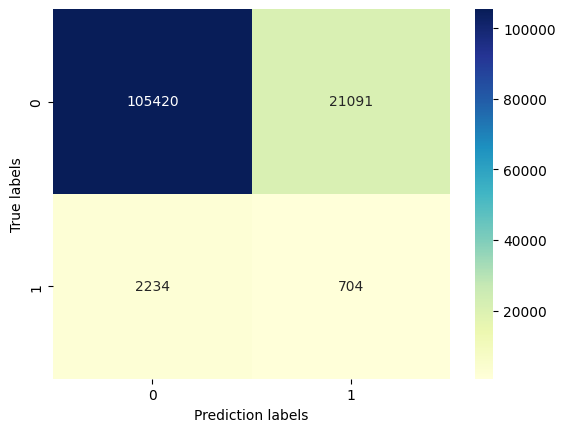

In [165]:
get_clf_eval(y_val_A, y_pred_A)

정확도: 0.725137
정밀도: 0.048250
재현율: 0.293487
AUC: 0.518848
F1: 0.082875


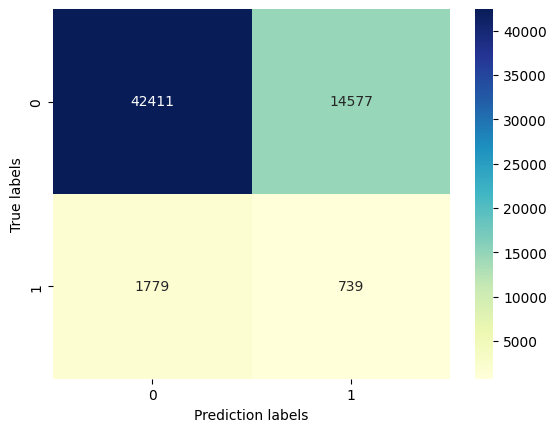

In [166]:
get_clf_eval(y_val_B, y_pred_B)

In [167]:
test_pred = model_A.predict(X_pre_val_A)

정확도: 0.967918
정밀도: 0.052980
재현율: 0.024506
AUC: 0.507167
F1: 0.033512


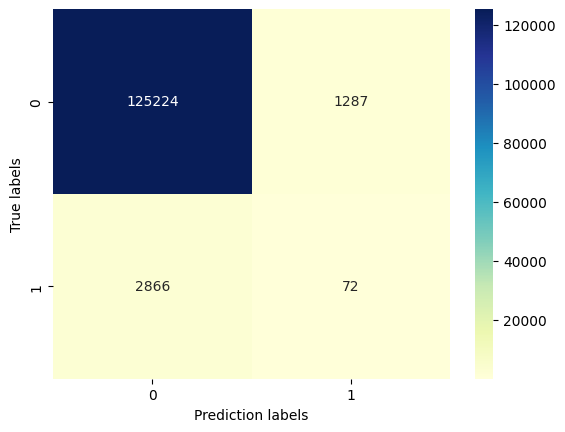

In [168]:
get_clf_eval(y_val_A, test_pred)

In [169]:
test_pred = model_B.predict(X_pre_val_B)

정확도: 0.948308
정밀도: 0.039604
재현율: 0.009531
AUC: 0.499659
F1: 0.015365


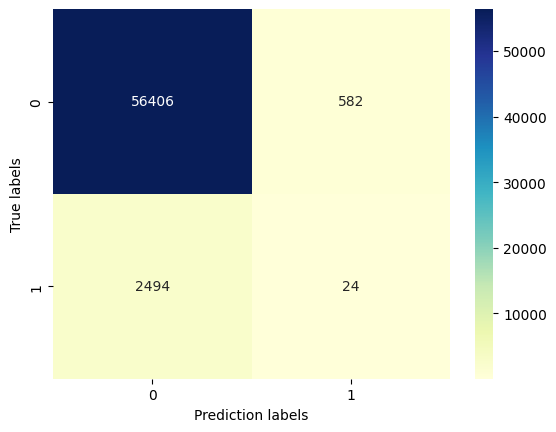

In [170]:
get_clf_eval(y_val_B, test_pred)

In [171]:
pipe_A_ = Pipeline([('prep', preprocess_A), ('model', model_A)])
pipe_B_ = Pipeline([('prep', preprocess_B), ('model', model_B)])

In [172]:
pipe_A_

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [173]:
import os
import joblib

# 모델 저장 경로
os.makedirs("./model", exist_ok=True)

joblib.dump(pipe_A_, "./model/model_A_pipeline.joblib")
joblib.dump(pipe_B_, "./model/model_B_pipeline.joblib")   # ★ 통째로 저장

print("모델 저장 완료: ./model/lgbm_A.pkl, ./model/lgbm_B.pkl")

모델 저장 완료: ./model/lgbm_A.pkl, ./model/lgbm_B.pkl


In [174]:
joblib.dump(target_col, "./model/target_col_A.joblib")
joblib.dump(target_col_B, "./model/target_col_B.joblib")   # ★ 통째로 저장


['./model/target_col_B.joblib']

In [114]:
pwd

'c:\\Users\\Kwon\\Desktop\\open_v2'

In [ ]:
0.0002604763431008905
0.0007075310568325222
0.00022502509818878025
0.0014135633828118443
0.10944760590791702
0.0005211815005168319
0.021798744797706604
0.21979956328868866
0.02254953421652317
0.00317776738665998

In [ ]:
0.0017785861855372787
0.0027763848192989826
2.8929198379046284e-05
2.0180244973744266e-05
0.0017288776580244303
3.954762632929487e-06
0.0322246178984642
0.1708998829126358
0.01315577607601881
2.4323146135429852e-05